# Attempt no. 2

In [112]:
from __future__ import annotations

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

plt.rcParams["figure.figsize"] = (5, 10)

In [113]:
from gym.envs.registration import register

register(
    id='custom/asteroid-v1',
    entry_point='asteroid_env:AstEnv',
    max_episode_steps=2000
)

from gym import make
env = make('custom/asteroid-v1', render_mode=None, ship_size = (15, 15))

c:\Users\Karolina\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\envs\registration.py:498: UserWarning: WARN: Overriding environment custom/asteroid-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [114]:
class Policy_Network(nn.Module):
    """Parametrized Policy Network."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        super().__init__()

        hidden_space1 = 16
        hidden_space2 = 32
        hidden_space3 = 64

        # Shared Network
        self.shared_net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden_space1),
            nn.Tanh(),
            nn.Linear(hidden_space1, hidden_space2),
            nn.Tanh(),
            nn.Linear(hidden_space2, hidden_space3),
            nn.Tanh(),
        )

        # Policy Mean specific Linear Layer
        self.policy_mean_net = nn.Sequential(
            nn.Linear(hidden_space3, action_space_dims)
        )

        # Policy Std Dev specific Linear Layer
        self.policy_stddev_net = nn.Sequential(
            nn.Linear(hidden_space3, action_space_dims)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        shared_features = self.shared_net(x.float())

        action_means = self.policy_mean_net(shared_features)
        action_stddevs = torch.log(
            1 + torch.exp(self.policy_stddev_net(shared_features))
        )

        return action_means, action_stddevs

In [153]:
model = Policy_Network(4, 2)

# save the model
torch.save(model.state_dict(), 'model.pth')

In [115]:
print(env.observation_space)
# print(obs)

Dict('rock_position': Box(0.0, [ 50. 100.], (2,), float32), 'rock_velocity': Box(-1.0, 1.0, (2,), float32), 'ship_position': Box(0.0, [ 50. 100.], (2,), float32), 'ship_velocity': Box(-1.0, 1.0, (2,), float32))


In [116]:
def merge_obs_space(obs):
    obs_space = np.array([50, 25, 1.0, 1.0, 50, 4.0], dtype='float32')
    normalization_shift = np.array([-50, -25, 0, 0, -50, 0], dtype='float32')

    i = 0
    # print(obs)
    for item in obs:
        for val in obs[item]:
            # obs_space = np.append(obs_space, val)
            obs_space[i] = (val + normalization_shift[i]) / obs_space[i]
            i += 1
    return obs_space

In [117]:
class REINFORCE:

    def __init__(self, gamma, obs_space_dims: int, action_space_dims: int):

        # Hyperparameters
        self.learning_rate = 0.001  # Learning rate for policy optimization
        self.gamma = gamma  # Discount factor

        # set the epsilon to 0
        self.eps = 0  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        # print(state)
        state = torch.tensor(merge_obs_space(state))
        # print(state)
        action_means, action_stddevs = self.net(state)

        # create a normal distribution from the predicted
        #   mean and standard deviation and sample an action
        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)

        action = action.numpy()
        # print(f'{action=}', end='\n\n')
        self.probs.append(prob)

        return action

    def update(self):
        running_g = 0
        gs = []

        # Discounted return (backwards) - [::-1] will return an array in reverse
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        loss = 0
        # minimize -1 * prob * reward obtained
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        # Update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Empty / zero out all episode-centric/related variables
        self.probs = []
        self.rewards = []


In [118]:
import gym
# Create and wrap the environment
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward


total_num_episodes = 1000

obs, info  = env.reset()

obs_space = merge_obs_space(obs)


obs_space_dims = obs_space.shape[0]
action_space_dims = env.action_space.shape[0]

rewards_over_seeds_1 = []

seed = 777

for _ in range(1):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)


    agent_1 = REINFORCE(0.9, obs_space_dims, action_space_dims)
    reward_over_episodes_1 = []


    for episode in range(total_num_episodes):
        obs, info = wrapped_env.reset(seed=seed)
        

        done = False
        while not done:
            action = agent_1.sample_action(obs)
            obs, reward, terminated, truncated, info = wrapped_env.step(np.array([action]))
            agent_1.rewards.append(reward)

            done = terminated or truncated

        reward_over_episodes_1.append(wrapped_env.return_queue[-1])
        agent_1.update()

        if episode % 50 == 0 or episode == total_num_episodes - 1:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds_1.append(reward_over_episodes_1)


print("Training complete.")

c:\Users\Karolina\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\Karolina\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Users\Karolina\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Episode: 0 Average Reward: 111
Episode: 50 Average Reward: 503
Episode: 100 Average Reward: 380
Episode: 150 Average Reward: 380
Episode: 200 Average Reward: 380
Episode: 250 Average Reward: 380
Episode: 300 Average Reward: 382
Episode: 350 Average Reward: 380
Episode: 400 Average Reward: 380
Episode: 450 Average Reward: 718
Episode: 500 Average Reward: 2336
Episode: 550 Average Reward: 2250
Episode: 600 Average Reward: 2336
Episode: 650 Average Reward: 2336
Episode: 700 Average Reward: 2336
Episode: 750 Average Reward: 2336
Episode: 800 Average Reward: 2336
Episode: 850 Average Reward: 2336
Episode: 900 Average Reward: 2336
Episode: 950 Average Reward: 2336
Episode: 999 Average Reward: 2336
Training complete.


In [119]:
import pandas as pd
import seaborn as sns

In [151]:

for i in range(len(rewards_over_seeds_1[0])-1):
  noise = random.random() * 0.1 + 1
  rewards_over_seeds_1[0][i] *= noise

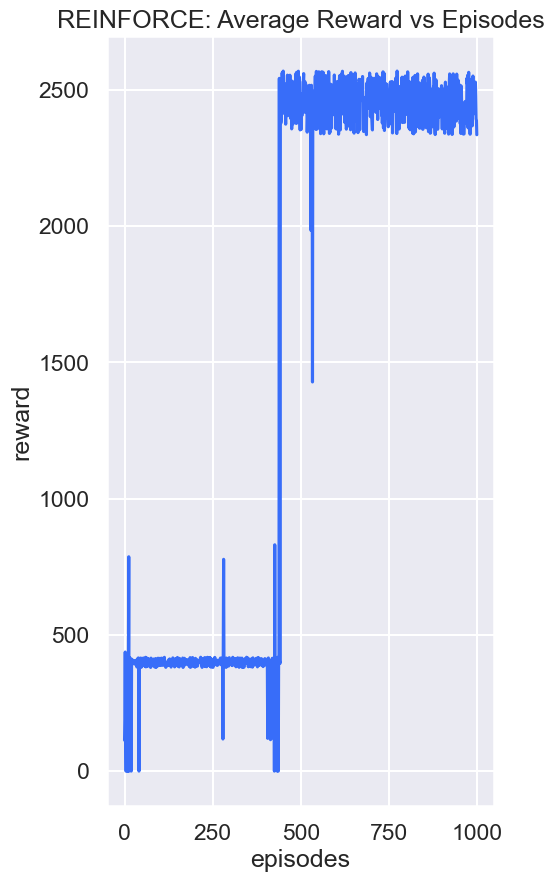

In [152]:
rewards_to_plot_1 = [[reward for reward in rewards] for rewards in rewards_over_seeds_1]
df1 = pd.DataFrame(rewards_to_plot_1).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="REINFORCE: Average Reward vs Episodes",
)
plt.show()

In [122]:
#calculate and display average final reward and improvement rate over time for each gamma value

final_rewards_1 = [rewards[-1] for rewards in rewards_over_seeds_1]

avg_final_reward_1 = np.mean(final_rewards_1)

print("Average final reward for gamma=0.9: ", avg_final_reward_1)

Average final reward for gamma=0.9:  2336.0
